### 참고자료: DACON [Team_Zoo] 특별편 4. 비지도학습 기반의 이상탐지 활용(feat. 시계열)

# Autoencoder based Anomaly Detection

본 코드는 오토인코더 기반의 이상탐지 모델을 활용하였습니다.

Conv1D-LSTM 기반의 Autoencoder 모델을 구현하였으며 구현 시 라이브러리는 tensorflow의 keras를 이용했습니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# from tqdm.notebook import trange
# from TaPR_pkg import etapr
from pathlib import Path
import time

# from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping

# 1) 데이터 불러오기

In [2]:
TRAIN_DATASET = pd.read_csv('./open/train.csv') # Train
VALIDATION_DATASET = pd.read_csv('./open/val.csv') # Validation

In [3]:
TRAIN_DF = TRAIN_DATASET.copy().drop(columns=['ID', 'V29', 'V30'])
TRAIN_DF

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,8.655320,...,-0.571605,3.490065,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864
113838,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,-0.283278,-0.153997,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068
113839,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.290491,-0.139512,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265
113840,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,0.128904,0.000676,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803


# 학습 모델 설정

모델 구현 라이브러리는 keras를 사용하였습니다.

본 챌린지의 핵심은 정상 상황의 데이터만을 학습하여 공격 및 비정상 상황을 탐지하는 것입니다.

Autoencoder의 경우 보통 이미지의 생성이나 복원에 많이 사용되며, 정상적인 이미지로 모델 학습 후 비정상적인 이미지를 넣어 이를 디코딩 하게 되면 정상 이미지 특성과 디코딩 된 이미지 간의 차이인 재구성 손실(Reconstruction Error)를 계산하게 됩니다. 이 재구성 손실이 낮은 부분은 정상(normal), 재구성 손실이 높은 부분은 이상(Abnormal)로 판단할 수 있습니다.

본 연구에서는 이러한 Anomaly Detection 방법을 이미지가 아닌 시계열 데이터에 적용하였습니다.

Autoencoder의 레이어를 LSTM으로 구성하여 시퀸스 학습이 가능하게 하였습니다.
또한, !D-Convolution layer를 적용하여 timestamp와 feature 정보를 세밀하게 이동하면서 학습이 진행되도록 하였습니다.

In [4]:
def temporalize(X, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(X) - timesteps - 1):
        t = []
        for j in range(1, timesteps + 1):
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

위의 함수를 통해서 데이터 셋 자체를 timestamp로 나누어서 학습을 진행할 수 있지만,
Conv1D 레이어를 활용하였기 때문에 timestamp는 1로 두고 3 차원의 shpae 형태로 만들어 주었습니다.

In [5]:
train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(113842, 1, 28)

In [29]:
VALIDATION_DATASET.columns

Index(['ID', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'Class'],
      dtype='object')

In [32]:
VALIDATION_DF = VALIDATION_DATASET.copy().drop(columns=['ID', 'V29', 'V30', 'Class'])
val_df = np.array(VALIDATION_DF)
val_train_x = val_df.reshape(val_df.shape[0], 1, val_df.shape[1])
val_train_x.shape

(28462, 1, 28)

In [33]:
val_train_y = VALIDATION_DATASET['Class']

# 학습 모델의 구조

파라미터 설명

Conv1D
- filters : 컨볼루션 연산의 output 출력 수
- kernel_size : timestamp를 얼마만큼 볼 것인가(=window_size)
- padding : 한 쪽 방향으로 얼마만큼 padding할 것인가
- dilation: kernel 내부에서 얼마만큼의 간격으로 kernel을 적용할 것인가
- stride: default = 1, 컨볼루션 레이어의 이동크기

LSTM
- unit: 출력 차원층만 설정

모델의 구조는 Conv1D - Dense층 - LSTM - Dense층으로 encoder 와 decoder가 대칭이 되도록 설계하였습니다.
파라미터는 주로 filters, kernel_size, Dense, LSTM의 units 값을 조절하면서 실험을 진행하였습니다.
파라미터 값을 수정하면서 많은 실험을 진행하였지만 다음과 같은 모델의 결과가 가장 좋았습니다.

추가적으로 Conv1D 레이어를 추가하거나 maxpooling과 같이 기존의 CNN 모델과 동일한 방식을 적용할 수 있습니다.

제가 실험을 할 때는 pooling을 적용하지 않는 것이 결과가 좋았지만 모델을 테스트 해보실 분들은 다양하게 
레이어와 파라미터 값을 조절 하면서 해보시면 좋을 것 같습니다.

In [66]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    # keras.backend.clear_session()

    model = Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="sigmoid"),
            layers.Dense(128),
            layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.Dense(64),
            layers.RepeatVector(n_steps),
            layers.Dense(64),
            layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Dense(128),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="sigmoid"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='sigmoid'))
        ]
    )
    return model

# 모델 구조 확인

In [67]:
model = conv_auto_model(x_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1, 512)            918016    
_________________________________________________________________
dense_15 (Dense)             (None, 1, 128)            65664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 1, 64)             4160      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)            

# 모델 학습하기
epoch을 50으로 하고, earlystopping을 사용하였습니다.
제출 코드에서는 예시로 에폭을 3회만 실시 하였습니다.

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

epochs = 1
batch = 64

# fit
history = model.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                    #  validation_split=0.2,
                     validation_data=(val_train_x, val_train_y), 
                     callbacks=[early_stopping]).history
                                               
model.save('./model_sigmoid.h5')

1779/1779 [==============================] - 1343s 752ms/step - loss: 1.0806 - val_loss: 0.0011


In [56]:
history

{'loss': [0.3698967695236206], 'val_loss': [0.8642895817756653]}

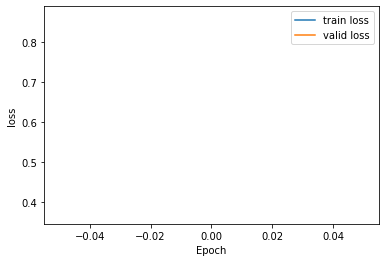

In [57]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# 학습된 모델 불러오기

In [58]:
model = load_model('./model_increasetodecrease.h5')

# 학습된 모델을 검증 데이터셋에 적용하여 이상 탐지

In [13]:
VALIDATION_DF = VALIDATION_DATASET.copy().drop(columns=['ID', 'V29', 'V30', 'Class'])

# Data cleaning
모델을 실험하면서 최종결과를 확인할 때 복원이 잘 되는 것을 확인할 수 있었지만,
앞부분의 정상구간이 다른 정상구간 보다 Reconstruction_error가 높게 나타나는 것을 알 수 있었습니다.

그래서 확인을 했을 때 한 변수가 정상인 구간에서 1이 넘어가는 값을 가지고 있었습니다.

validation set에서 조금 더 정교하게 threshold 조절 및 결과를 확인하기 위해서 해당 변수의 값을 정상 범위에 맞게 임의로 조절하였습니다.

하지만 이부분은 특이한 경우로 validation에서는 정답 label 값을 알고 있고, 정상이지만 비정상 구간에서 일정하게 나타나고 있었기 때문에 조절하였습니다.

In [59]:
val = np.array(VALIDATION_DF)
x_val = val.reshape(val.shape[0], 1, val.shape[1])
x_val.shape

(28462, 1, 28)

모델의 결과가 3차원의 형태이기 때문에 복원된 결과와의 차이를 확인하기 위해서는 2차원으로 다시 바꿔줘야합니다.

그래서 flatten 함수를 구현하여 활용하였습니다.

In [39]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

모델의 의해 재구성된 값을 실제 값과 차이를 구해서 재구성 손실(reconstruction error) 값을 구해줍니다.

정상인경우 모델이 잘 학습되어 복원이 잘 되었기 때문에 reconstruction error 값이 작게 나올 것이고,
공격인 경우 정규화된 값에서 0과 1을 벗어나기 때문에 reconstruction error 값이 크게 나올 것입니다.

In [60]:
start = time.time()
valid_x_predictions = model.predict(x_val)
print(valid_x_predictions.shape)

error = flatten(x_val) - flatten(valid_x_predictions)
print((flatten(x_val) - flatten(valid_x_predictions)).shape)

valid_mse = np.mean(np.power(flatten(x_val) - flatten(valid_x_predictions), 2), axis=1)
print(valid_mse.shape)
print(time.time()-start)

(28462, 1, 28)
(28462, 28)
(28462,)
11.411235570907593


# Precision Recall Curve

threshold의 경우 Recall과 Precision의 값이 교차되는 지점을 기준으로 조금 씩 수정하면서 결과를 확인하였습니다.

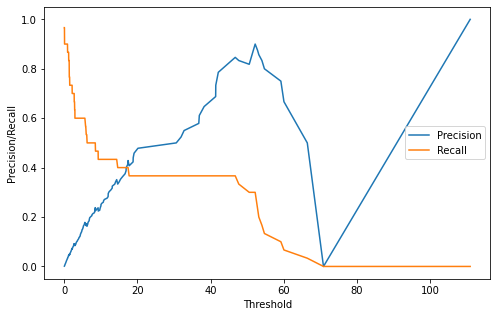

In [61]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse, 
                         'True_class':list(VALIDATION_DATASET['Class'])})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [62]:
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.4 , recall:  0.4
threshold:  17.393550638073613


# Predict Validation data set
우선 위에서 구한 threshold의 값으로 시각화를 하여 결과를 확인해 보겠습니다.

Text(0.5, 0, 'Data point index')

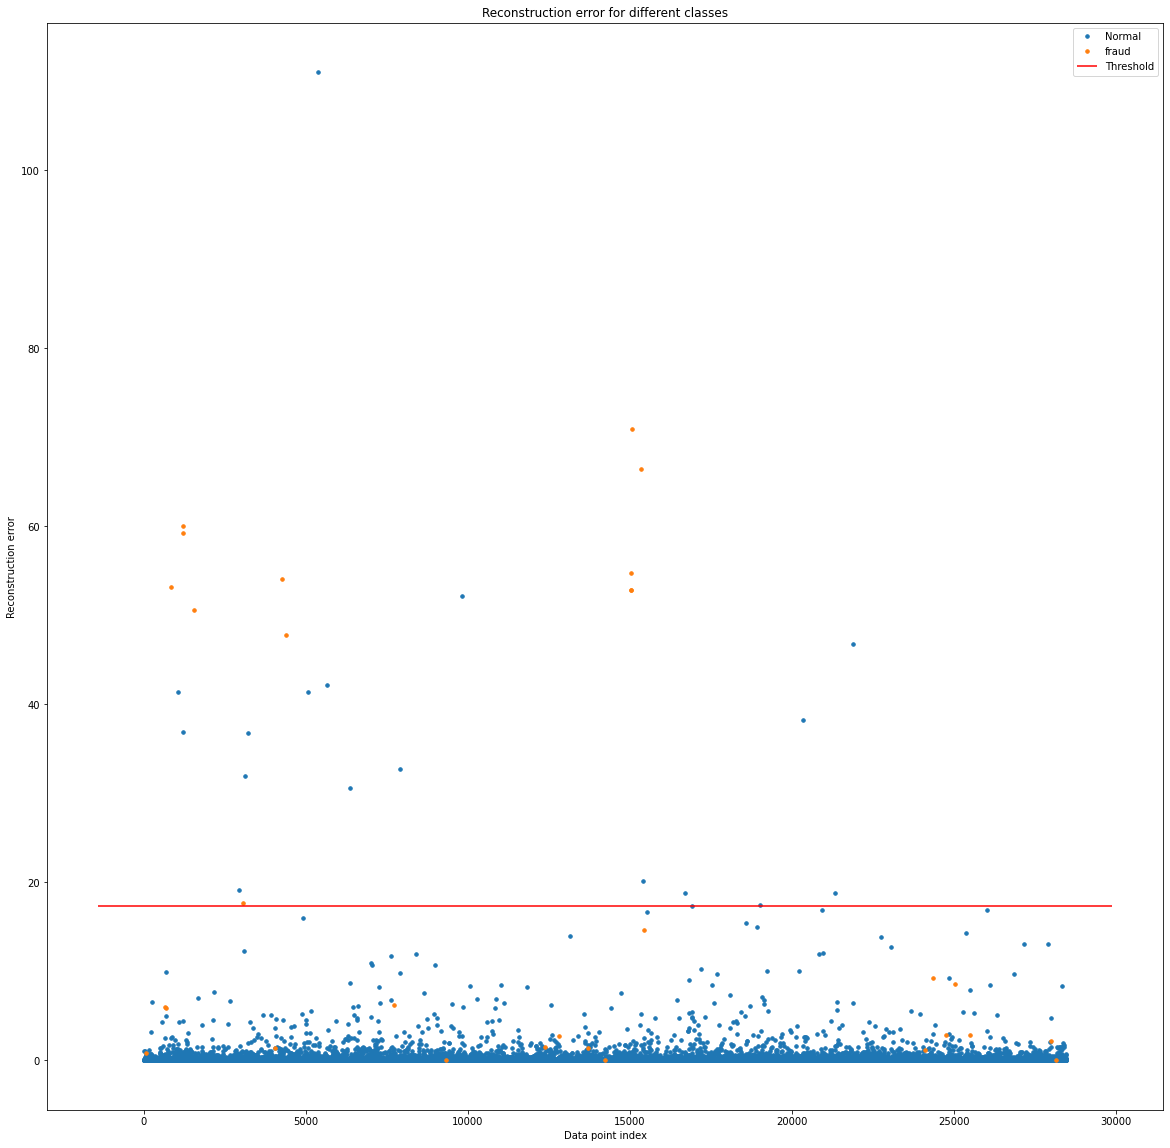

In [63]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse ,
                         'True_class': list(VALIDATION_DATASET['Class'])})
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "fraud" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [64]:
pred_y = [1 if e > 30 else 0 for e in error_df['Reconstruction_error'].values]
pred_y = np.array(pred_y)
pred_y.shape

(28462,)

# 평가

In [65]:
ACTUAL_LABELS = np.array(VALIDATION_DATASET['Class'])
PRED_LABELS = np.array(pred_y)

ACTUAL_LABELS.shape[0] == PRED_LABELS.shape[0]

from sklearn.metrics import f1_score
f1_score(ACTUAL_LABELS, PRED_LABELS, average='macro')

0.7072746231706779

# test set

In [21]:
test_df = pd.read_csv('./open/test.csv') # Train
test_x = test_df.drop(columns=['ID', 'V29', 'V30'])

In [22]:
test = np.array(test_x)
x_test = test.reshape(test.shape[0], 1, test.shape[1])

In [23]:
test_x_predictions = model.predict(x_test)
print(test_x_predictions.shape)

error = flatten(x_test) - flatten(test_x_predictions)
print((flatten(x_test) - flatten(test_x_predictions)).shape)

test_mse = np.mean(np.power(flatten(x_test) - flatten(test_x_predictions), 2), axis=1)
print(test_mse.shape)

(142503, 1, 28)
(142503, 28)
(142503,)


In [33]:
test_error = pd.DataFrame({'Reconstruction_error': test_mse})

# test_move = test_error['Reconstruction_error'].rolling(71).mean()

# test_d = test_move.fillna(0)
# test_d


# movemean_test = pd.DataFrame({'Reconstruction_error': test_d})

pred_y_test = [1 if e > threshold_fixed*0.5 else 0 for e in test_error['Reconstruction_error'].values]
pred_y_test = np.array(pred_y_test)
pred_y_test.shape

(142503,)

In [34]:
## Submission
submit = pd.read_csv('./open/sample_submission.csv')
submit['Class'] = pred_y_test
submit.to_csv('./submit_ae_lstm.csv', index=False)
pd.read_csv('./submit_ae_lstm.csv')['Class'].sum()

364